In [1]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os
import category_encoders as ce

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [47]:
# Read csv into dataframe.
df = pd.read_csv('Data/210907_Essay_score_cleaned_3.csv')

In [48]:
# Deal with isna's and dtypes.
cols = ['Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('N/A')
df = df.drop(['Unnamed: 0', 'Code'], axis=1)

In [52]:
for col in ['PTJ1', 'SMK1']:
    df[col] = np.log(df[col] - 170)

In [53]:
df.head()

,Country,PTJ1,SMK1,Sex,Age,Grade,Major,Field,VST,CEFR,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna
0,CHN,4.615121,3.891820,F,20,2.0,Law,Social Sciences,30.0,B1_1,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,72.0,0.0,0.0,0,1,1
1,CHN,3.496508,4.804021,F,21,3.0,Law,Social Sciences,27.0,B1_1,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,77.0,0.0,0.0,0,1,1
2,CHN,4.219508,4.382027,F,20,3.0,Law,Social Sciences,32.0,B1_1,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,79.0,0.0,0.0,0,1,1
3,CHN,4.595120,4.094345,F,20,2.0,Chemistry,Sciences & Technology,37.0,B1_2,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,87.0,0.0,0.0,0,1,1
4,CHN,4.007333,3.637586,M,20,2.0,Chemistry,Sciences & Technology,44.0,B1_2,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,84.0,0.0,0.0,0,1,1


In [54]:
# Subset X and y.
X = df.drop(['VST'], axis=1).copy()
y = df.VST.copy()

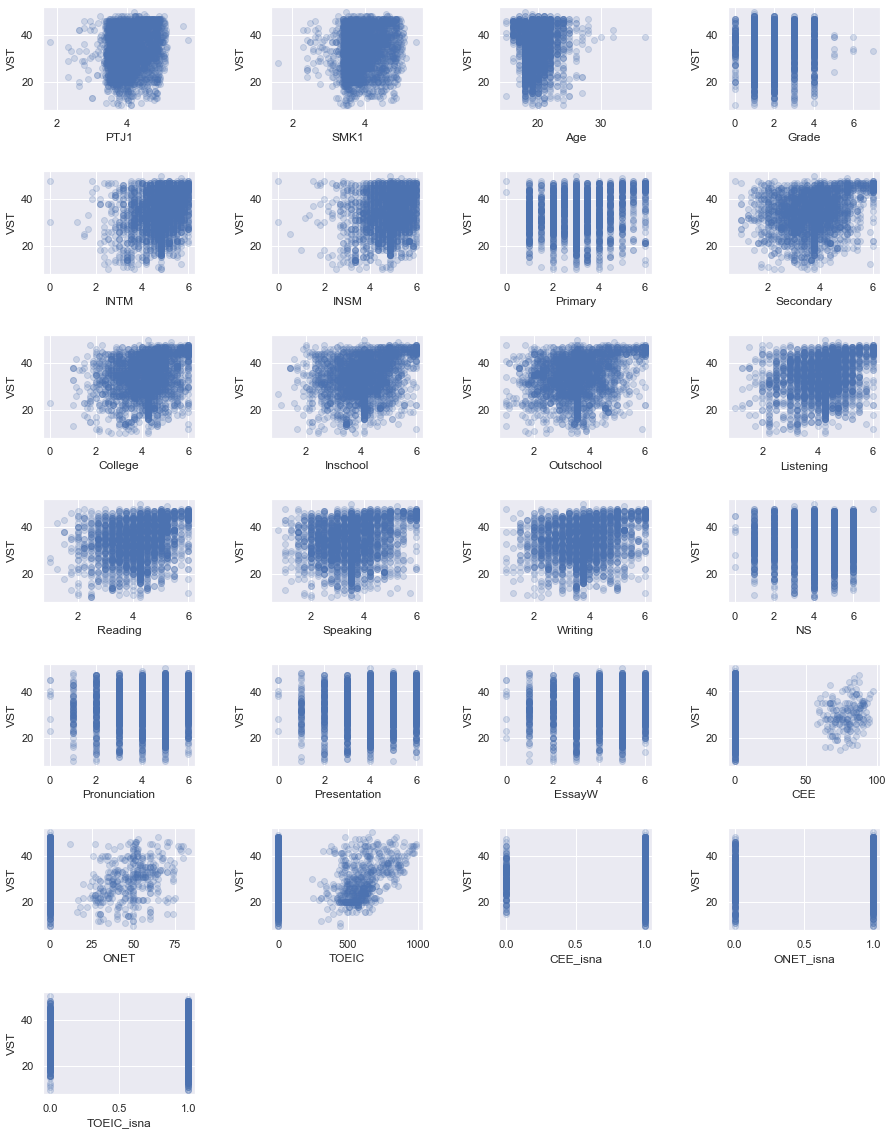

In [55]:
# Quick EDA for feature analysis.
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'VST', data=df, ncol=4, figsize=(15, 20))

In [56]:
ce_hash = ce.HashingEncoder(cols=['Major'])
X = ce_hash.fit_transform(X)

C:\Users\jaeyo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [57]:
# Get dummies
X = pd.get_dummies(X, dtype='int64')
X.shape

(2600, 54)

In [58]:
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,PTJ1,SMK1,Age,Grade,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna,Country_CHN,Country_HKG,Country_IDN,Country_JPN,Country_KOR,Country_PAK,Country_PHL,Country_SIN,Country_THA,Country_TWN,Sex_F,Sex_M,Field_Humanities,Field_Life Sciences,Field_N/A,Field_Sciences & Technology,Field_Social Sciences,CEFR_A2_0,CEFR_B1_1,CEFR_B1_2,CEFR_B2_0
0,0,1,0,0,0,0,0,0,4.615121,3.891820,20,2.0,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,72.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,0,3.496508,4.804021,21,3.0,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,77.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,0,0,4.219508,4.382027,20,3.0,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,79.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,4.595120,4.094345,20,2.0,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,87.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,0,0,4.007333,3.637586,20,2.0,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,84.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [59]:
# Train Test split. Check their shapes and types
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(1950, 54) (650, 54) (1950,) (650,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [60]:
# Random Forest Regressor - initialize
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Parameter grid for gridsearch
params = {
    'n_estimators': [int(n) for n in np.logspace(1,3,5)],
    'max_depth': [None, 10, 20, 30]
}

# 3-fold CV Grid Search, fit, and show top five CV stats.
rf_grid_cv = RandomizedSearchCV(rf, params, cv=3, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'n_estimators': 316, 'max_depth': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,2.394848,0.098568,1.057049,0.396172,316,None,"{'n_estimators': 316, 'max_depth': None}",0.757864,0.796088,0.751094,0.768348,0.019808,1
1,2.748027,0.156689,0.422900,0.241569,316,20,"{'n_estimators': 316, 'max_depth': 20}",0.758022,0.795517,0.751056,0.768199,0.019526,2
6,8.562267,0.067596,0.148270,0.012987,1000,20,"{'n_estimators': 1000, 'max_depth': 20}",0.757754,0.794015,0.752387,0.768052,0.018489,3
9,2.353135,0.177319,1.385848,0.119816,100,20,"{'n_estimators': 100, 'max_depth': 20}",0.758966,0.796086,0.748245,0.767766,0.020498,4
2,0.591070,0.287582,0.554681,0.308207,100,10,"{'n_estimators': 100, 'max_depth': 10}",0.757664,0.794444,0.749728,0.767279,0.019480,5


In [62]:
# Parameter grid for gridsearch
params = {
    'n_estimators': [int(n) for n in np.logspace(2,3,3)],
    'max_depth': [None, 20, 30]
}

# 3-fold CV Grid Search, fit, and show top five CV stats.
rf_grid_cv = GridSearchCV(rf, params, cv=3, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'max_depth': None, 'n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,10.644656,0.427200,1.571061,0.444192,None,1000,"{'max_depth': None, 'n_estimators': 1000}",0.758501,0.794203,0.753424,0.768709,0.018145,1
8,9.489950,0.805552,0.393852,0.241458,30,1000,"{'max_depth': 30, 'n_estimators': 1000}",0.758500,0.794248,0.753377,0.768708,0.018180,2
1,2.724100,0.077260,0.749603,0.096383,None,316,"{'max_depth': None, 'n_estimators': 316}",0.757864,0.796088,0.751094,0.768348,0.019808,3
7,4.899764,0.237377,1.406797,0.282787,30,316,"{'max_depth': 30, 'n_estimators': 316}",0.757912,0.796073,0.750883,0.768289,0.019855,4
4,5.786640,0.079140,1.469646,0.063198,20,316,"{'max_depth': 20, 'n_estimators': 316}",0.758022,0.795517,0.751056,0.768199,0.019526,5


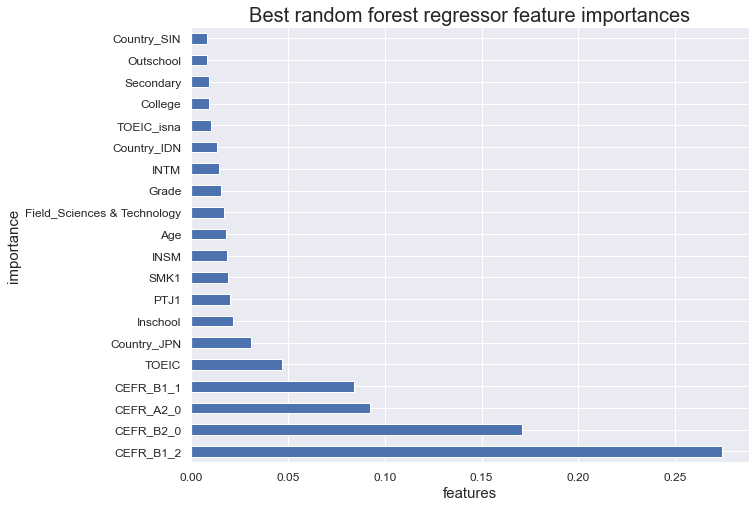

In [63]:
# Manually store best RF estimator as rf_best. Fit to training set.
rf_best = RandomForestRegressor(random_state=42, max_depth=None, n_estimators=1000, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Plot the top 20 feature importances.
plt.subplots(figsize=(10, 8))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
_ = rf_feat_imps.plot(kind='barh', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

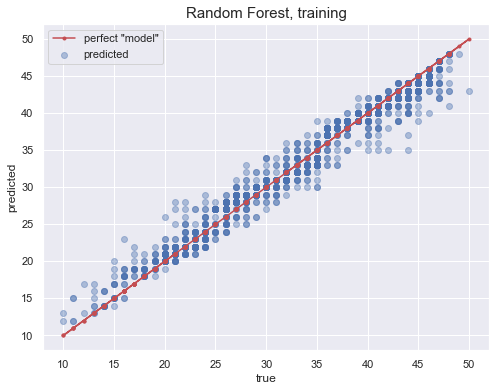

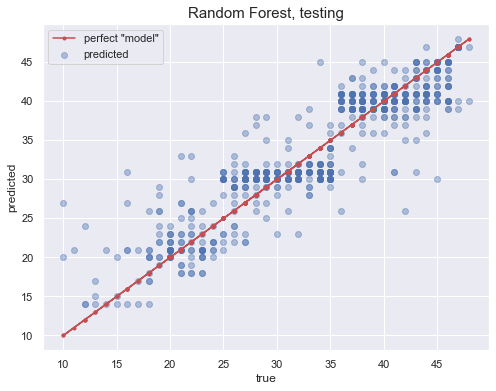

In [64]:
# Predict Training and Test sets with Rf model
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [65]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.8292853796803229
RMSE:  3.629349650366493


In [66]:
# XG Boost - initialize.
xg = XGBRegressor(objective='reg:linear', seed=42)
xgb.set_config(verbosity=0)

# Parameter grid for grid searching.
params = {
    'max_depth': range(1, 11),
    'n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
    'learning_rate': [n for n in np.logspace(start=-3, stop=0, num=4)]
}

# 3-fold CV Grid search, fit, and print CV stats for top five estimators
xg_grid_cv = RandomizedSearchCV(xg, params, cv=3, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'n_estimators': 316, 'max_depth': 6, 'learning_rate': 0.01}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,2.972684,0.294262,0.005338,0.000483,316,6,0.01,"{'n_estimators': 316, 'max_depth': 6, 'learnin...",0.725255,0.722389,0.702677,0.716774,0.010036,1
9,0.084172,0.003538,0.004158,0.000240,31,2,0.1,"{'n_estimators': 31, 'max_depth': 2, 'learning...",0.666543,0.691103,0.655164,0.670937,0.014997,2
2,3.033556,0.065086,0.006330,0.000630,1000,2,1.0,"{'n_estimators': 1000, 'max_depth': 2, 'learni...",0.594206,0.646304,0.593838,0.611449,0.024647,3
0,1.868763,0.015108,0.004989,0.000012,316,7,1.0,"{'n_estimators': 316, 'max_depth': 7, 'learnin...",0.587279,0.572570,0.644539,0.601463,0.031046,4
8,1.073251,0.011422,0.007164,0.000614,316,3,1.0,"{'n_estimators': 316, 'max_depth': 3, 'learnin...",0.598997,0.578193,0.611578,0.596256,0.013766,5


In [69]:
# Parameter grid for grid searching.
params = {
    'max_depth': range(2, 8),
    'n_estimators': [int(n) for n in np.logspace(start=2, stop=3, num=3)],
    'learning_rate': [n for n in np.logspace(start=-2, stop=-1, num=3)]
}

# 3-fold CV Grid search, fit, and print CV stats for top five estimators
xg_grid_cv = RandomizedSearchCV(xg, params, cv=3, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:3]

{'n_estimators': 316, 'max_depth': 6, 'learning_rate': 0.03162277660168379}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,2.017264,0.069078,0.004847,0.000248,316,6,0.031623,"{'n_estimators': 316, 'max_depth': 6, 'learnin...",0.747669,0.761292,0.748144,0.752368,0.006313,1
4,0.673599,0.044342,0.004991,0.000820,100,5,0.1,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.746912,0.759405,0.746114,0.750810,0.006086,2
2,6.721797,0.068047,0.008341,0.000462,1000,5,0.031623,"{'n_estimators': 1000, 'max_depth': 5, 'learni...",0.728574,0.757485,0.734303,0.740121,0.012499,3


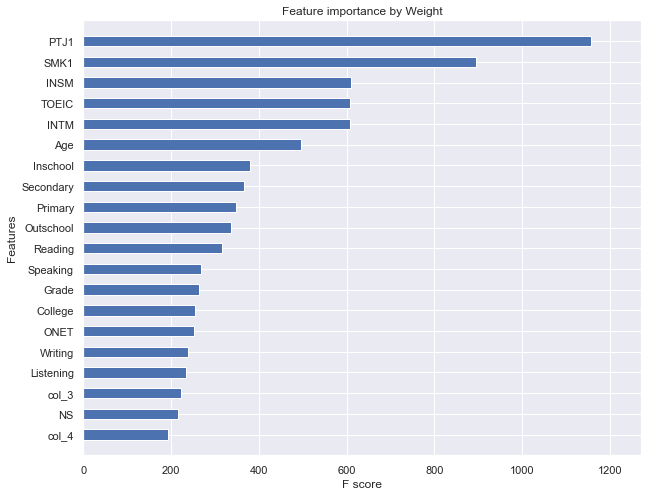

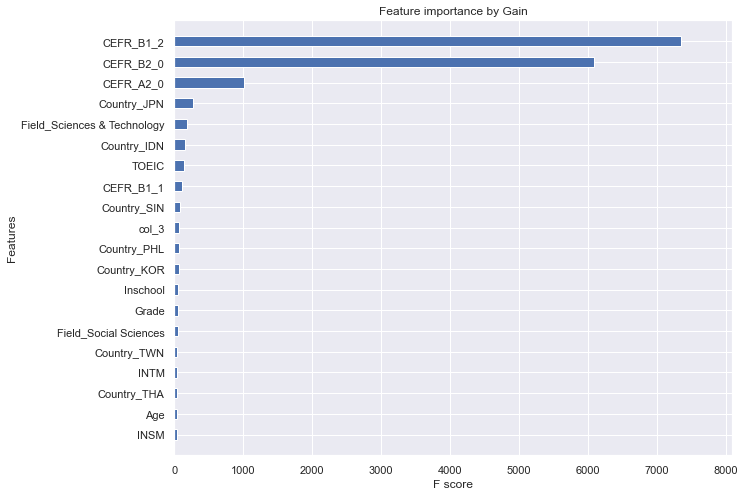

In [70]:
# Manually store best XG Boost model as xg_best. Fit to training set.
xg_best = XGBRegressor(objective='reg:linear', learning_rate=0.031623, max_depth=6, n_estimators=316, seed=42)
xg_best.fit(X_train, y_train)

# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

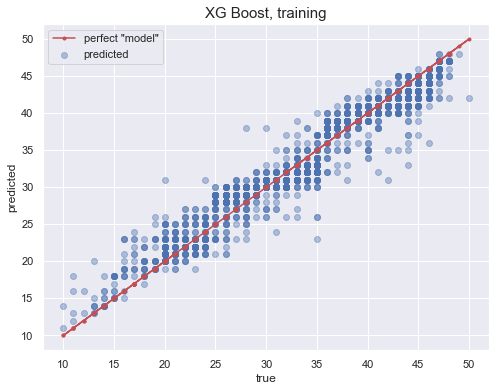

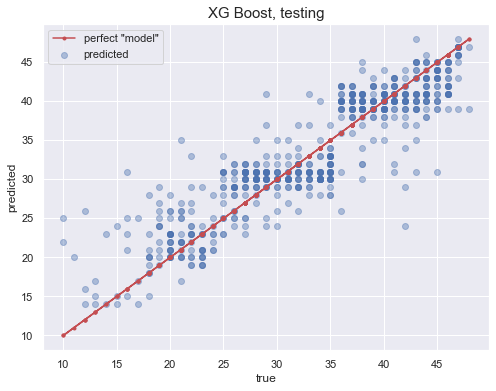

In [71]:
# Predict on Training and Test sets using XG Boost model
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, np.round(y_tr_xg_pred))
pred_plot("XG Boost, testing", y_test, np.round(y_te_xg_pred))

In [72]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.8219451959029793
RMSE:  3.7065537272461078


In [74]:
# Initialize pipeline for optional StandardScaler followed by Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipe = make_pipeline(scaler, lasso)

# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [StandardScaler(), None],
    'lasso__alpha': [n for n in np.logspace(-6,4,22)]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe, params, cv=3, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 0.0007196856730011514, 'standardscaler': None}


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19644.61334750168, tolerance: 14.61748517948718
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.098917,0.015956,0.003497,4.075296e-04,0.00072,None,"{'lasso__alpha': 0.0007196856730011514, 'stand...",0.683720,0.715632,0.708866,0.702739,0.013729,1
11,0.094079,0.007392,0.004988,1.412706e-03,0.00024,None,"{'lasso__alpha': 0.00024040991835099718, 'stan...",0.683639,0.715335,0.709235,0.702736,0.013732,2
10,0.098074,0.008359,0.004319,4.723301e-04,0.00024,StandardScaler(),"{'lasso__alpha': 0.00024040991835099718, 'stan...",0.683615,0.715289,0.709266,0.702723,0.013733,3
12,0.095256,0.006935,0.004988,6.836514e-07,0.00072,StandardScaler(),"{'lasso__alpha': 0.0007196856730011514, 'stand...",0.683659,0.715501,0.708974,0.702712,0.013733,4
9,0.088098,0.003083,0.003657,4.700217e-04,0.00008,None,"{'lasso__alpha': 8.030857221391521e-05, 'stand...",0.683593,0.715235,0.709240,0.702690,0.013723,5


In [75]:
# Set lasso_best to alpha=0.00072. Fit to training set.
lasso_best = Lasso(alpha=0.00072, random_state=42)
lasso_best.fit(X_train, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19644.080054979913, tolerance: 14.61748517948718
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.00072, random_state=42)

In [76]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0.2]

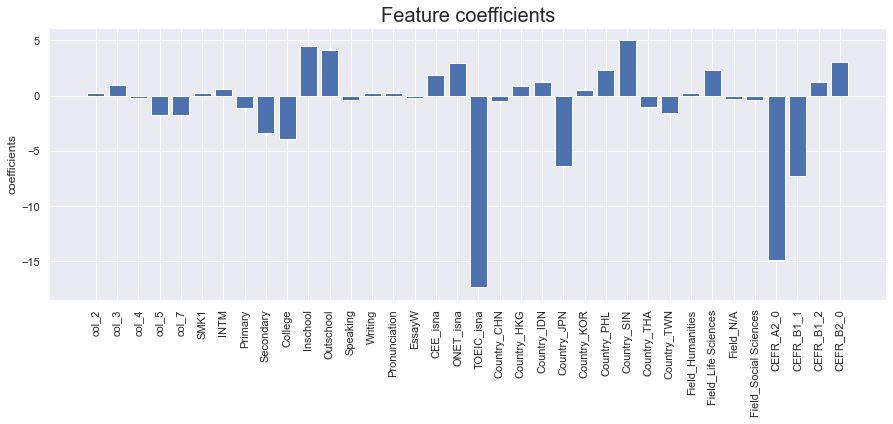

In [77]:
# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

In [78]:
# Store means of non-zero entries of each column to list means. This is for scaling the Lasso coefficients.
means = []
for c in X_train.columns:
    means.append(X_train[X_train[c] != 0][c].mean())

# For plotting purposes - keep only the scaled coefficients of absolute value > 0.2 to keep the plot visually comprehensible
scaled_coefs = pd.DataFrame(lasso_best.coef_ * means, index=X_train.columns, columns=['scaled_coef']).fillna(0)
scaled_coefs = scaled_coefs[abs(scaled_coefs.scaled_coef) > 0.2]

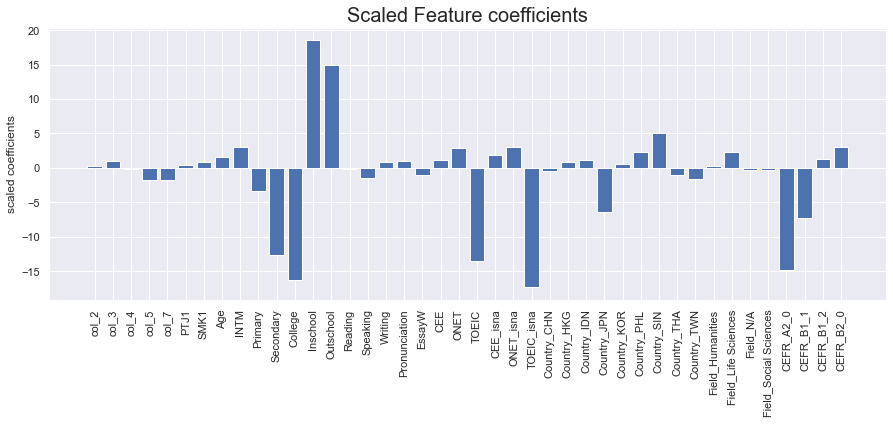

In [79]:
# Plot scaled feature coefficients of Lasso Regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(scaled_coefs.index, scaled_coefs.scaled_coef)
plt.xticks(rotation='vertical')
plt.ylabel('scaled coefficients')
plt.title('Scaled Feature coefficients', fontsize=20)
plt.show()

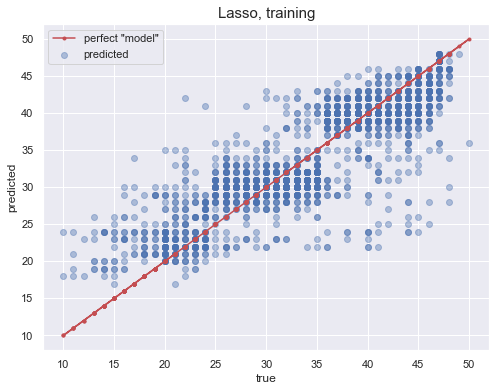

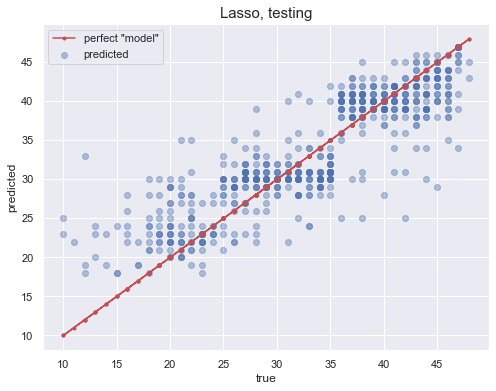

In [80]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_train)
y_te_lasso_pred = lasso_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, np.round(y_tr_lasso_pred))
pred_plot("Lasso, testing", y_test, np.round(y_te_lasso_pred))

In [81]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.7635124184016041
RMSE:  4.271669282879677


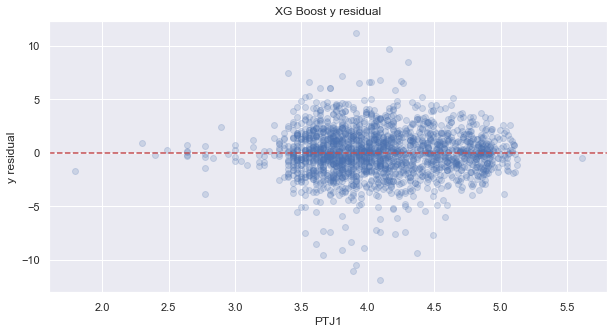

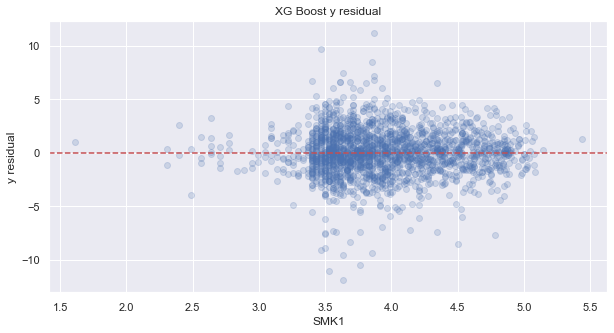

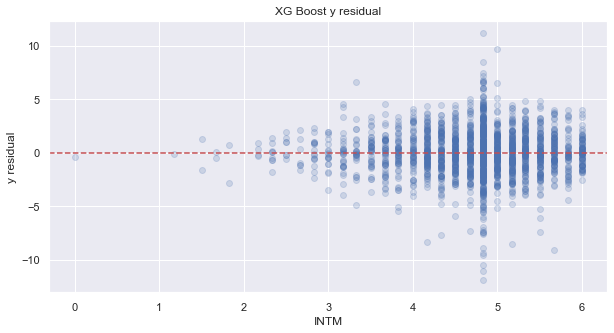

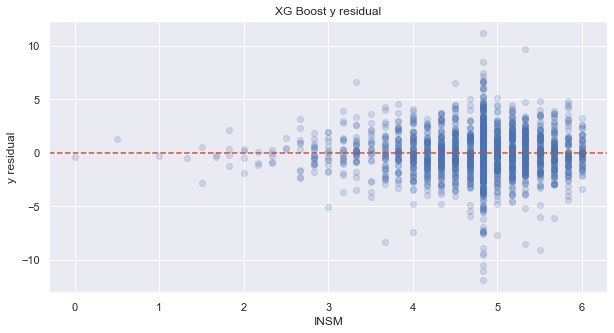

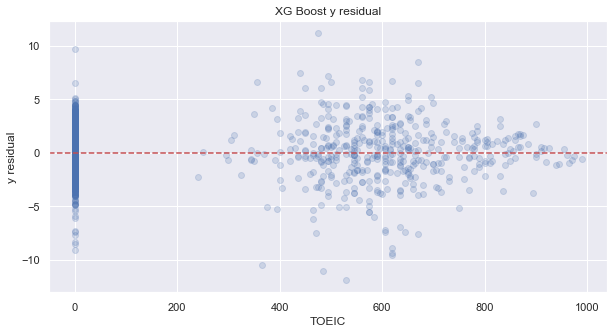

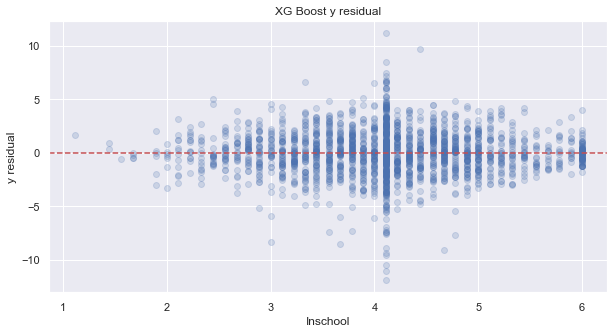

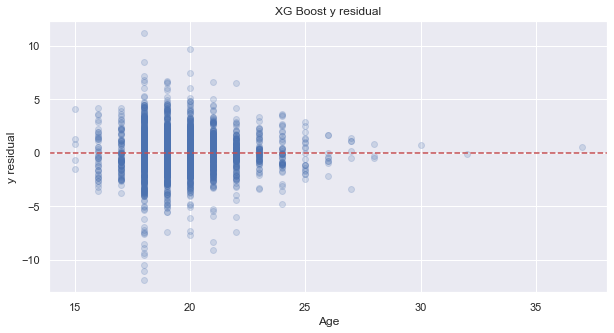

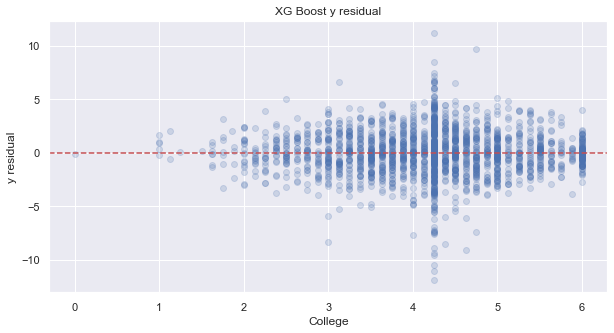

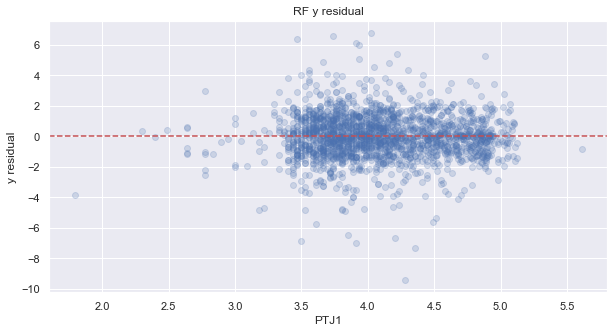

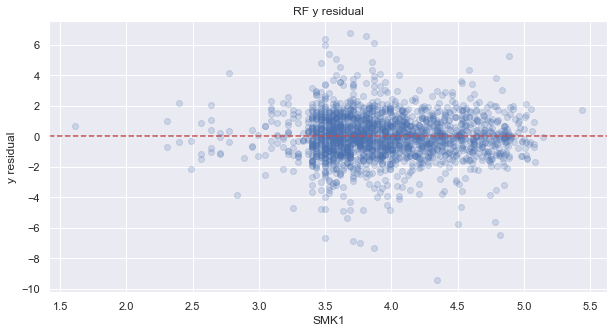

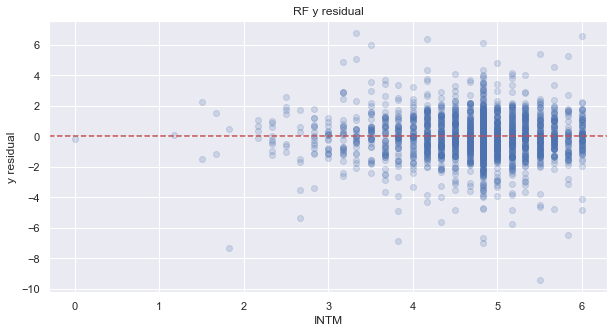

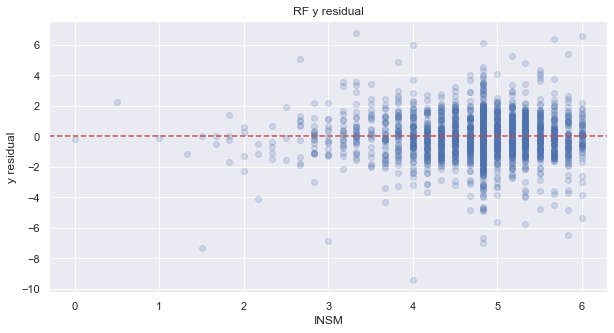

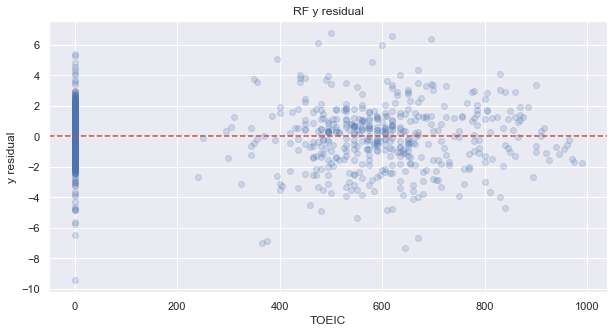

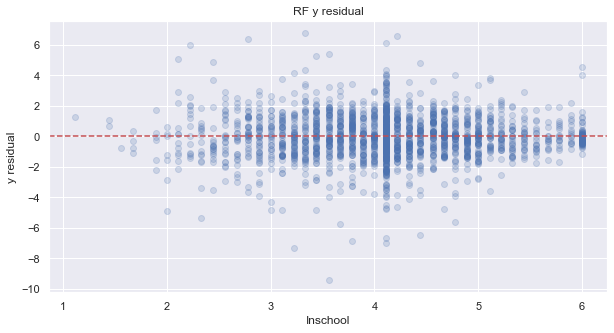

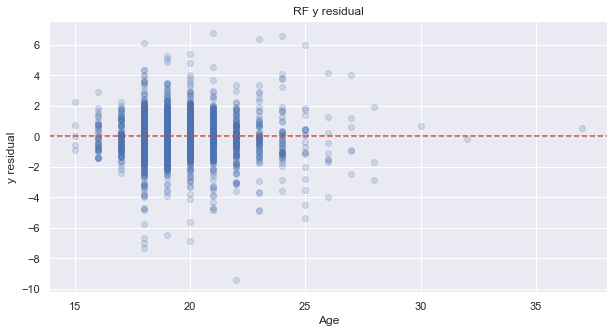

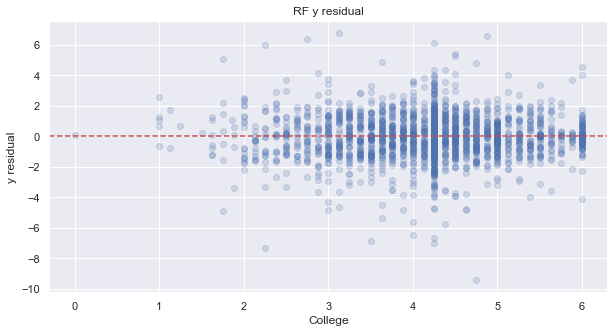

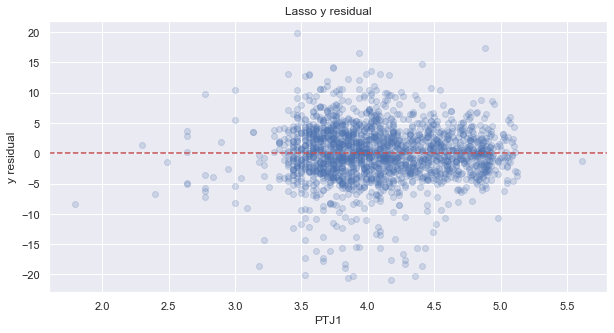

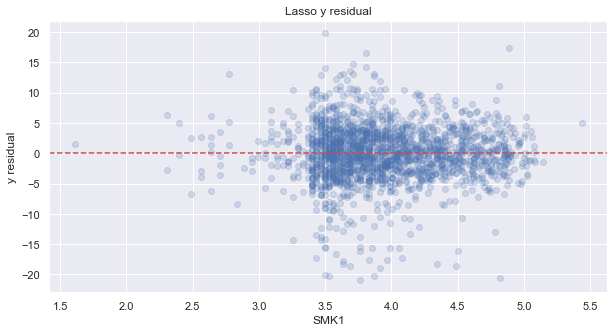

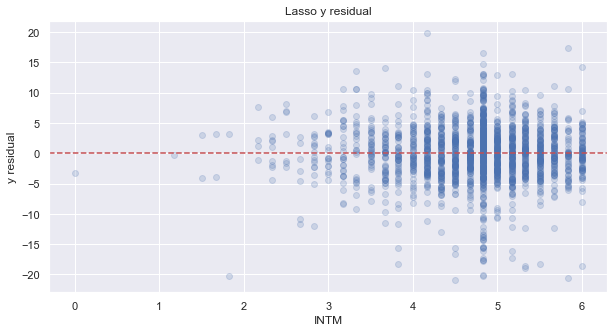

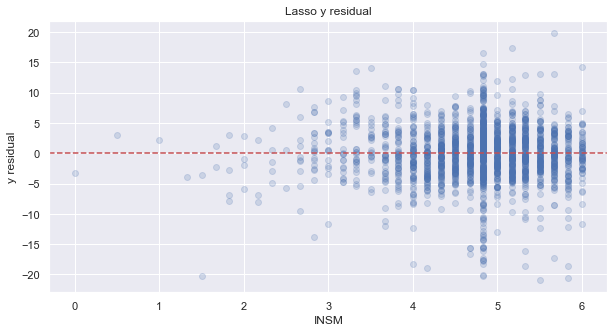

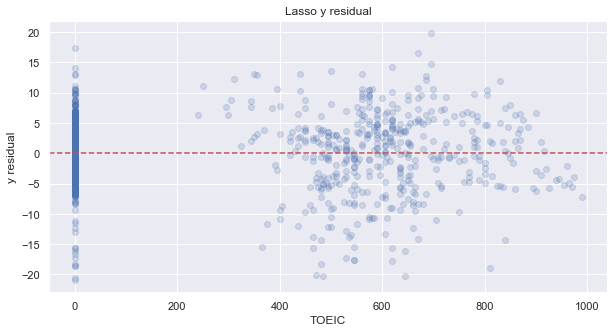

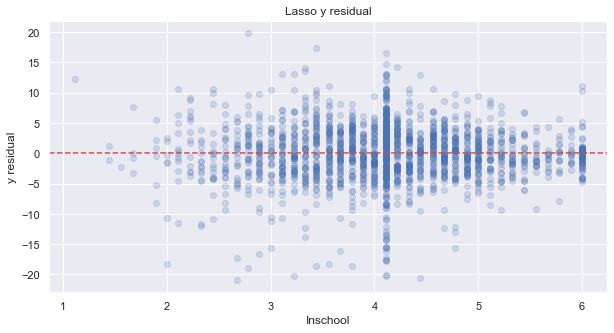

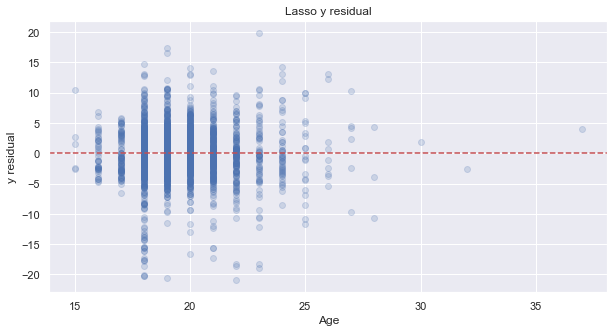

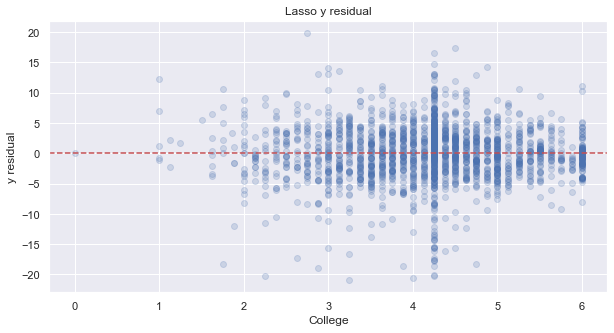

In [82]:
# Highest weight continuous columns for XG Boost
cols = ['PTJ1', 'SMK1', 'INTM', 'INSM', 'TOEIC', 'Inschool', 'Age', 'College']

# XG Boost Training prediction residuals
y_tr_xg_res = y_tr_xg_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_xg_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('XG Boost y residual')
    plt.show()
    
# RF Training prediction residuals
y_tr_rf_res = y_tr_rf_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_rf_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('RF y residual')
    plt.show()
    
# Lasso Training prediction residuals
y_tr_lasso_res = y_tr_lasso_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_lasso_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('Lasso y residual')
    plt.show()